# Pruning Pathfinder

In [1]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

import pandas as pd
from quetzal.model import stepmodel
from quetzal.engine.pathfinder_utils import efficient_od_sets

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [2]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'

## Read Model

In [3]:
sm = stepmodel.read_zippedpickles(model_folder + '/{scen}/walk_model'.format(scen=scenario))

distribution = stepmodel.read_zippedpickles((model_folder + '/{scen}/distribution'.format(scen=scenario)))
sm.volumes = distribution.volumes

volumes: 100%|██████████| 3/3 [00:00<00:00, 633.90it/s]


## BEST PATHS

In [4]:
tc = sm.copy()
tc.step_pt_pathfinder(
    broken_routes = False,
    broken_modes = False,
    keep_pathfinder = True,
    mode_column = 'route_type',
    route_column = 'route_short_name',
    speedup = True,
    cutoff = 6000, # Max path length
    walk_on_road = False, # Using footpaths
    path_analysis = True,
    engine ='b', # b is faster
)

ppf = tc.publicpathfinder
tc.pt_los.head(5)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 52578.82it/s]


,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
0,zone_0,zone_0,0.000000,"(zone_0,)",best_path,False,[],[],[],[],[],[],[],[],[],True,0,0.0,0.0
1,zone_0,zone_1,1131.460117,"(zone_0, 93, zone_1)",best_path,False,[],[],[93],[],[],"[(zone_0, 93), (93, zone_1)]",[],[],[],True,0,0.0,0.0
2,zone_0,zone_10,1562.727558,"(zone_0, 183, link_3656, 10, link_4524, link_4...",best_path,False,"[183, 10]","[10, 147]","[183, 10, 147]","[link_3656, link_4524, link_4525]",[],"[(zone_0, 183), (147, zone_10)]",[10],"[link_3656, link_4524]","[link_3656, link_4525]",False,1,300.0,NaN
3,zone_0,zone_100,2084.450306,"(zone_0, 93, link_4717, link_4718, 267, link_4...",best_path,False,"[93, 267, 180]","[267, 180, 24]","[93, 267, 180, 24]","[link_4717, link_4718, link_4474, link_5361, l...",[],"[(zone_0, 93), (24, zone_100)]","[267, 180]","[link_4717, link_4474, link_5361]","[link_4718, link_4474, link_5362]",False,2,540.0,NaN
4,zone_0,zone_101,1810.577095,"(zone_0, 93, link_4303, link_4304, 30, link_49...",best_path,False,"[93, 30, 100, 40]","[30, 100, 40, 28]","[93, 30, 100, 40, 28]","[link_4303, link_4304, link_4966, link_4967, l...",[],"[(zone_0, 93), (28, zone_101)]","[30, 100, 40]","[link_4303, link_4966, link_4406, link_5125]","[link_4304, link_4969, link_4407, link_5126]",False,3,660.0,NaN


# Route and Mode Breaker (pruning)
### Routes Breaker: 
We remove, each time, one line of type Tram, Rail or Subway

In [5]:
ppf.combinations = dict()
rail = tc.links.loc[tc.links['route_type'].isin(['tram', 'subway', 'rail'])] 
broken_routes = rail["route_short_name"].unique()
ppf.combinations['route_id'] = [{route} for route in broken_routes]
print('Broken Routes:', broken_routes)

Broken Routes: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '3B' '7B'
 'T3B' 'T2' 'T3A' 'C' 'D' 'E' 'L' 'A' 'B']


### Mode Breaker
We remove one mode at the time then we remove all modes to generate "all walk" path

In [6]:
mode_combinations = []
mode_combinations.append(set(tc.links['route_type'].unique()))
for mode in tc.links['route_type'].unique():
    mode_combinations.append({mode})
print('Broken Modes Combinaison:', mode_combinations)

Broken Modes Combinaison: [{'rail', 'bus', 'tram', 'subway'}, {'bus'}, {'subway'}, {'tram'}, {'rail'}]


### OD Sets
For a faster iterations, we limit pathfinder to OD that show be affected by the removed line

In [7]:
ppf.combinations = dict()
ppf.links['route_id'] = ppf.links['route_short_name']
ppf.combinations['route_id'] = [{route} for route in broken_routes]
ppf.combinations['route_type'] = mode_combinations
ppf.build_route_id_sets(first_and_last_only=True)
ppf.build_route_type_sets(first_and_last_only=False)
ppf.build_od_sets()

ppf.splitted_od_sets['route_id'] = {
    c : efficient_od_sets(od_set, factor=0.6, verbose=False) 
    for c, od_set in ppf.od_sets['route_id'].items()
}

### Route Breaker Pathfinder

In [8]:
ppf.find_broken_combination_paths(column='route_id', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_route_paths = ppf.broken_combination_paths
ppf.broken_route_paths['pathfinder_session'] = 'route_breaker' 
ppf.broken_route_paths['broken_route'] = ppf.broken_route_paths['broken_route_id'].apply(lambda s: list(s)[0] )

route_id {'C'}: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]  


### Mode Breaker Pathfinder

In [9]:
ppf.find_broken_combination_paths(column='route_type', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_mode_paths = ppf.broken_combination_paths
ppf.broken_mode_paths['pathfinder_session'] = 'mode_breaker'
ppf.broken_mode_paths['broken_modes'] = ppf.broken_mode_paths['broken_route_type'].apply(set)

route_type {'rail'}: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]  


### Concatenate paths

In [10]:
pt_los = pd.concat([
    ppf.best_paths,
    ppf.broken_mode_paths, 
    ppf.broken_route_paths, 
    ]
)
pt_los['path'] = [tuple(p) for p in pt_los['path']]
pt_los = pt_los.drop_duplicates(subset=['path'])
pt_los['time'] = pt_los['gtime']
print('Total path: ', len(pt_los))
tc.pt_los = pt_los
pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

Total path:  51298


mode_breaker     25649
route_breaker    13549
best_path        12100
Name: pathfinder_session, dtype: int64

# Export

In [11]:
tc.to_zippedpickles((model_folder + '/{scen}/pruning_pt_pathfinder'.format(scen=scenario)))

pt_los: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]                 


# Plot

In [12]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


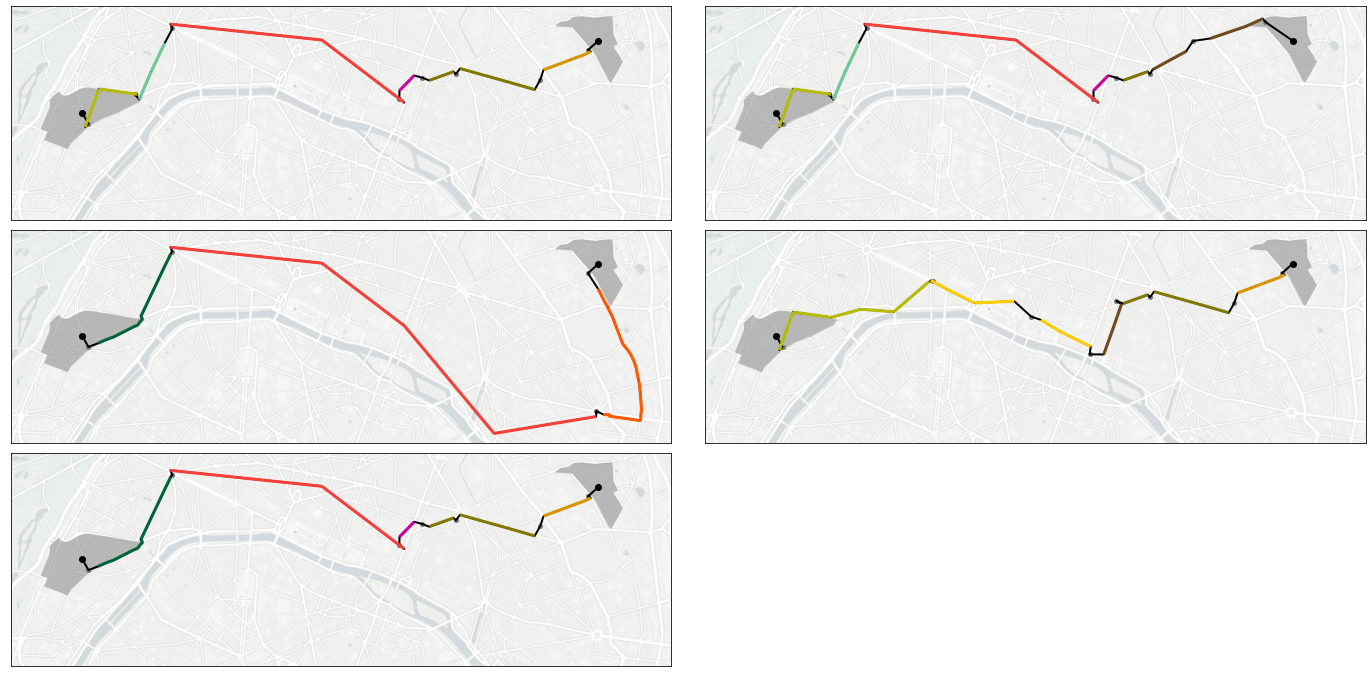

In [13]:
tc.links['color'] = '#' + tc.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = tc.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', 
)

# END